# Imports
Classification of radio signals using Pytorch

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms as T


#given images of spectograms the model will classify or will give us the probabilities
#In this dataset there is 4 classes as shown below
#radio signals converted into spectogram

![](Untitled-design.png)

# Configurations

In [2]:
TRAIN_CSV='train.csv'
VALID_CSV='valid.csv'
BATCH_SIZE=128
DEVICE='cpu'
MODEL_NAME='efficientnet_b0'
LR=0.001
EPOCHS=15


In [3]:
df_train=pd.read_csv(TRAIN_CSV)
df_valid=pd.read_csv(VALID_CSV)
df_train.head()
#all of this column represents each pixel values of the spectogram image
#pixel values of the spectogram image

,0,1,2,3,4,5,6,7,8,9,...,8183,8184,8185,8186,8187,8188,8189,8190,8191,labels
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667,Squiggle
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490,Squiggle
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510,Squiggle
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,...,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373,Squiggle
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,...,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412,Squiggle


In [4]:
df_train.tail()

,0,1,2,3,4,5,6,7,8,9,...,8183,8184,8185,8186,8187,8188,8189,8190,8191,labels
3195,0.631373,0.666667,0.627451,0.607843,0.639216,0.615686,0.623529,0.588235,0.611765,0.635294,...,0.611765,0.596078,0.607843,0.639216,0.658824,0.643137,0.627451,0.607843,0.647059,Narrowband
3196,0.662745,0.627451,0.686275,0.615686,0.639216,0.717647,0.674510,0.643137,0.729412,0.701961,...,0.627451,0.662745,0.654902,0.701961,0.701961,0.647059,0.615686,0.635294,0.623529,Narrowband
3197,0.647059,0.650980,0.643137,0.596078,0.529412,0.568627,0.607843,0.631373,0.635294,0.658824,...,0.658824,0.639216,0.647059,0.619608,0.603922,0.603922,0.643137,0.619608,0.564706,Narrowband
3198,0.694118,0.709804,0.580392,0.650980,0.631373,0.686275,0.623529,0.650980,0.678431,0.666667,...,0.674510,0.615686,0.686275,0.670588,0.619608,0.678431,0.682353,0.623529,0.647059,Narrowband
3199,0.631373,0.611765,0.701961,0.690196,0.658824,0.686275,0.643137,0.670588,0.662745,0.670588,...,0.662745,0.690196,0.698039,0.654902,0.666667,0.705882,0.650980,0.658824,0.686275,Narrowband


In [5]:
unique_labels = df_train['labels'].unique()
print(unique_labels)

['Squiggle' 'Narrowbanddrd' 'Noises' 'Narrowband']


In [6]:
print(f"No. of examples present in df_train : {len(df_train)}")
print(f"No. of examples present in df_valid : {len(df_valid)}")
print(f"Labels are : {df_train['labels'].unique()}")

No. of examples present in df_train : 3200
No. of examples present in df_valid : 800
Labels are : ['Squiggle' 'Narrowbanddrd' 'Noises' 'Narrowband']


Text(0.5, 1.0, 'Squiggle')

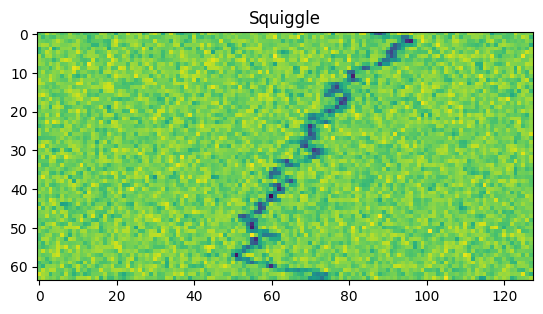

In [7]:
#gonna convert this 1D vector inot the image
index=8
row=df_train.iloc[index] #extracted second sample
image_pixels=np.array(row[0:8192],dtype=np.float64)#8192

#we have 8193 columns and last column is the label so gonna ignore that one
label=row.labels
image=np.resize(image_pixels,(64,128)) #64*128=8192

plt.imshow(image)
plt.title(label)

## Impact of ;

# Declare Spec Augmentations

![](image6.png)

In [8]:
from spec_augment import TimeMask, FreqMask

In [9]:
#for spectogram image it isn't like image augmentation (rotations...)
#the reason it changes the state of the audio signals
#here we will use spectogram augmentation spec augment
#two types of augmentation
#time mask (vertical strips) and A frequency (horizontal strips )
#spec augment research paper in which 3 augmentation techniques were described
#1st time mask
#2nd frequency mask
#3rd time bob
def get_train_transform():
    return T.Compose([
        TimeMask(T=15,num_masks=4),
        FreqMask(F=15,num_masks=3)
    ])


# Create Custom Dataset
return image and label pair
as before to show the result but in a class and method format

In [10]:
class SpecDataset(Dataset):
    def __init__(self,df,augmentations=None):
        self.df=df
        self.augmentations=augmentations
        label_mapper= {
            'Squiggle':0,
            'Narrowband':1,
            'Narrowbanddrd':2,
            'Noises':3
        }
        self.df.loc[:,'labels']=self.df.labels.map(label_mapper)#1s method

    def __len__(self):
        return len(self.df) #2nd method

    def __getitem__(self,index):
        row=self.df.iloc[index]
        image_pixels=np.array(row[0:8192],dtype=np.float64)
        image=np.resize(image_pixels,(64,128,1)) #1 represent the number of channels
        #(h,w,c)
        label=np.array(row.labels ,dtype=np.int64)
        image=torch.Tensor(image).permute(2,0,1)#(C,h,w)
        if self.augmentations != None:
            image=self.augmentations(image)
        return image.float(), label

In [11]:
train_set=SpecDataset(df_train,get_train_transform())
val_set=SpecDataset(df_valid)#No augmentation for validation



In [12]:
df_train.tail()

,0,1,2,3,4,5,6,7,8,9,...,8183,8184,8185,8186,8187,8188,8189,8190,8191,labels
3195,0.631373,0.666667,0.627451,0.607843,0.639216,0.615686,0.623529,0.588235,0.611765,0.635294,...,0.611765,0.596078,0.607843,0.639216,0.658824,0.643137,0.627451,0.607843,0.647059,1
3196,0.662745,0.627451,0.686275,0.615686,0.639216,0.717647,0.674510,0.643137,0.729412,0.701961,...,0.627451,0.662745,0.654902,0.701961,0.701961,0.647059,0.615686,0.635294,0.623529,1
3197,0.647059,0.650980,0.643137,0.596078,0.529412,0.568627,0.607843,0.631373,0.635294,0.658824,...,0.658824,0.639216,0.647059,0.619608,0.603922,0.603922,0.643137,0.619608,0.564706,1
3198,0.694118,0.709804,0.580392,0.650980,0.631373,0.686275,0.623529,0.650980,0.678431,0.666667,...,0.674510,0.615686,0.686275,0.670588,0.619608,0.678431,0.682353,0.623529,0.647059,1
3199,0.631373,0.611765,0.701961,0.690196,0.658824,0.686275,0.643137,0.670588,0.662745,0.670588,...,0.662745,0.690196,0.698039,0.654902,0.666667,0.705882,0.650980,0.658824,0.686275,1


In [13]:
print(len(df_train))

3200


In [14]:
df_train.dropna(subset=['labels'], inplace=True)

In [15]:
unique_labels = df_train['labels'].unique()
print(unique_labels)

[0 2 3 1]


0


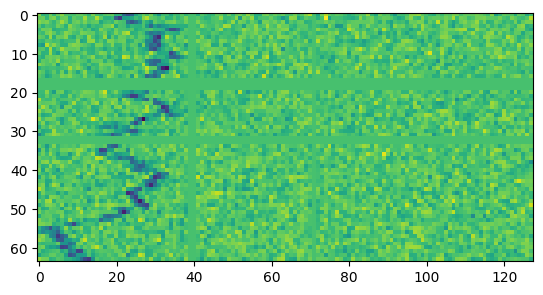

In [16]:
image, label = train_set[15]

plt.imshow(image.permute(0, 1, 2).squeeze())
print(label)

In the result shown above you can see the affect of Spectogram augmentation (of time and frequency masking
)
label is in form of a digit


# Load dataset into Batches

In [17]:
trainloader=DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True)
validloader=DataLoader(val_set,batch_size=BATCH_SIZE)

In [18]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 25
Total no. of batches in validloader : 7


In [19]:

for images , labels in trainloader:
    break;
print(f"One image batch shape : {images.shape}")#(batch size,channel dimension,height,width )
print(f"One label batch shape : {labels.shape}")#128 images in one batch

One image batch shape : torch.Size([128, 1, 64, 128])
One label batch shape : torch.Size([128])


# Load Model

In [20]:
!pip install timm

In [21]:
import timm

class SpecModel(nn.Module):
    def __init__(self, num_classes=4):
        super(SpecModel, self).__init__()
        MODEL_NAME = 'tf_efficientnet_b0'
        self.net = timm.create_model(MODEL_NAME, num_classes=4, pretrained=True, in_chans=1)

    def forward(self, images, labels = None):

        logits = self.net(images)

        if labels is not None:
            loss = nn.CrossEntropyLoss()
            return logits, loss(logits, labels)
        return logits

In [22]:
model =SpecModel()
model #; to remove the output

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


SpecModel(
  (net): EfficientNet(
    (conv_stem): Conv2dSame(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kerne

In [23]:
    def forward(self,images,labels=None):
        logits=self.net(images)
        #without precising the activation function so that it cn be changed as a parameter
        if labels !=None:
            loss=nn.CrossEntropyLoss()
            return logits
        return logits

In [24]:
 pip install utils

# Create Train and Eval Function

In [25]:
from tqdm.notebook import tqdm


In [26]:
from tqdm.notebook import tqdm

# Define the multiclass_accuracy function
def multiclass_accuracy(logits, labels):
    """
    Calculate the multiclass accuracy given logits and true labels.

    Args:
        logits (Tensor): Predicted logits from the model.
        labels (Tensor): True labels.

    Returns:
        accuracy (float): Multiclass accuracy.
    """
    # Calculate accuracy based on logits and labels
    predicted_labels = torch.argmax(logits, dim=1)
    correct_predictions = (predicted_labels == labels).sum().item()
    total_predictions = labels.size(0)

    accuracy = correct_predictions / total_predictions

    return accuracy

def train_fn(model, dataloader, optimizer, current_epoch):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    progress_bar = tqdm(dataloader, desc="EPOCH [TRAIN] " + str(current_epoch + 1) + '/' + str(EPOCHS))

    for t, data in enumerate(progress_bar):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits, labels)  # Use the locally defined function

        temp = {'loss': '%6.2f' % float(total_loss / (t + 1)), 'acc': '%6.4f' % float(total_acc / (t + 1))}

        progress_bar.set_postfix(temp)

    return total_loss / len(dataloader), total_acc / len(dataloader)


In [27]:
def valid_fn(model, dataloader, current_epoch):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    progress_bar = tqdm(dataloader, desc="EPOCH [VALID] " + str(current_epoch + 1) + '/' + str(EPOCHS))

    with torch.no_grad():
        for t, data in enumerate(progress_bar):
            images, labels = data
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            logits, loss = model(images, labels)

            total_loss += loss.item()
            total_acc += multiclass_accuracy(logits, labels)

            temp = {'loss' : '%6f' %float(total_loss/(t+1)), 'acc' : '%6f' %float(total_acc/(t+1))}

            progress_bar.set_postfix(temp)

        return total_loss/len(dataloader), total_acc/len(dataloader)

# Training Loop

In [28]:
def fit(model, trainloader, validloader, optimizer):
    best_valid_loss = np.inf

    for epoch in range(EPOCHS):
        # Training
        train_loss, train_acc = train_fn(model, trainloader, optimizer, epoch)

        # Validation
        valid_loss, valid_acc = valid_fn(model, validloader, epoch)

        # Check if the current validation loss is the best so far
        if valid_loss < best_valid_loss:
            torch.save(model.state_dict(), MODEL_NAME + '-best-weight.pt')
            print('SAVED-BEST-WEIGHTS')
            best_valid_loss = valid_loss

        # Print epoch-wise statistics
        print(f'Epoch [{epoch + 1}/{EPOCHS}]')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.2f}%')
        print('-' * 50)


In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
fit(model, trainloader, validloader, optimizer)

EPOCH [TRAIN] 1/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 1/15:   0%|          | 0/7 [00:00<?, ?it/s]

SAVED-BEST-WEIGHTS
Epoch [1/15]
Train Loss: 1.0909 | Train Acc: 0.70%
Valid Loss: 7.1307 | Valid Acc: 0.22%
--------------------------------------------------


EPOCH [TRAIN] 2/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 2/15:   0%|          | 0/7 [00:00<?, ?it/s]

SAVED-BEST-WEIGHTS
Epoch [2/15]
Train Loss: 0.4682 | Train Acc: 0.75%
Valid Loss: 0.8848 | Valid Acc: 0.66%
--------------------------------------------------


EPOCH [TRAIN] 3/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 3/15:   0%|          | 0/7 [00:00<?, ?it/s]

SAVED-BEST-WEIGHTS
Epoch [3/15]
Train Loss: 0.3880 | Train Acc: 0.76%
Valid Loss: 0.4024 | Valid Acc: 0.76%
--------------------------------------------------


EPOCH [TRAIN] 4/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 4/15:   0%|          | 0/7 [00:00<?, ?it/s]

SAVED-BEST-WEIGHTS
Epoch [4/15]
Train Loss: 0.3572 | Train Acc: 0.77%
Valid Loss: 0.3945 | Valid Acc: 0.77%
--------------------------------------------------


EPOCH [TRAIN] 5/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 5/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5/15]
Train Loss: 0.3578 | Train Acc: 0.78%
Valid Loss: 0.3969 | Valid Acc: 0.75%
--------------------------------------------------


EPOCH [TRAIN] 6/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 6/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6/15]
Train Loss: 0.3560 | Train Acc: 0.78%
Valid Loss: 0.4243 | Valid Acc: 0.71%
--------------------------------------------------


EPOCH [TRAIN] 7/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 7/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7/15]
Train Loss: 0.3581 | Train Acc: 0.78%
Valid Loss: 0.4047 | Valid Acc: 0.72%
--------------------------------------------------


EPOCH [TRAIN] 8/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 8/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8/15]
Train Loss: 0.3439 | Train Acc: 0.79%
Valid Loss: 0.4456 | Valid Acc: 0.72%
--------------------------------------------------


EPOCH [TRAIN] 9/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 9/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9/15]
Train Loss: 0.3381 | Train Acc: 0.81%
Valid Loss: 0.5446 | Valid Acc: 0.70%
--------------------------------------------------


EPOCH [TRAIN] 10/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 10/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [10/15]
Train Loss: 0.3322 | Train Acc: 0.81%
Valid Loss: 0.4480 | Valid Acc: 0.73%
--------------------------------------------------


EPOCH [TRAIN] 11/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 11/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [11/15]
Train Loss: 0.3007 | Train Acc: 0.84%
Valid Loss: 0.4383 | Valid Acc: 0.75%
--------------------------------------------------


EPOCH [TRAIN] 12/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 12/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [12/15]
Train Loss: 0.2761 | Train Acc: 0.86%
Valid Loss: 0.4906 | Valid Acc: 0.75%
--------------------------------------------------


EPOCH [TRAIN] 13/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 13/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [13/15]
Train Loss: 0.2729 | Train Acc: 0.86%
Valid Loss: 0.6986 | Valid Acc: 0.71%
--------------------------------------------------


EPOCH [TRAIN] 14/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 14/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [14/15]
Train Loss: 0.2400 | Train Acc: 0.88%
Valid Loss: 0.5564 | Valid Acc: 0.75%
--------------------------------------------------


EPOCH [TRAIN] 15/15:   0%|          | 0/25 [00:00<?, ?it/s]

EPOCH [VALID] 15/15:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [15/15]
Train Loss: 0.2251 | Train Acc: 0.90%
Valid Loss: 0.5796 | Valid Acc: 0.74%
--------------------------------------------------


# Inference

In [30]:
from utils import view_classify

In [32]:
idx= 17
model.load_state_dict(torch.load('/content/efficientnet_b0-best-weight.pt')) #copy path of best model pt
image,mask = val_set[idx]
logits_mask=model(image.to(DEVICE).unsqueeze(0)) #unsqueeze 0 gonna add an extra dimension
#(c,h,w)=>(b,c,h,w)
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0
#from the helper file we are going to use show image function

<ipython-input-32-ad12b4d4f30a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/efficientnet_b0-best-weight.pt')) #copy path of b

In [41]:
#import helper




#import helper
#helper.show_image(image,label)

AttributeError: module 'helper' has no attribute 'show_image'

In [38]:
#i mport helper

# Print all attributes of the helper module to check if show_image exists and to check for typos
#print(dir(helper))

['__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__']
